In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product

#define the mean average percentage error (MAPE), as this will be our error metric.

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [ ]:
import yfinance as yf

# Define the ticker symbol for the S&P 500 index
ticker_symbol = "TSLA"

# Define the desired date range for the historical data
start_date = "2018-06-27"
end_date = "2023-06-27"

# Download the historical data using yfinance
raw_data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Print the downloaded data
print(raw_data)

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2018-06-27   23.000000   23.386000   22.633333   22.966667   22.966667   
2018-06-28   23.243999   23.801332   23.073999   23.328667   23.328667   
2018-06-29   23.555332   23.590668   22.827333   22.863333   22.863333   
2018-07-02   24.004667   24.318666   21.990000   22.337999   22.337999   
2018-07-03   22.116667   22.166000   20.646000   20.724001   20.724001   
...                ...         ...         ...         ...         ...   
2023-06-20  261.500000  274.750000  261.119995  274.450012  274.450012   
2023-06-21  275.130005  276.989990  257.779999  259.459991  259.459991   
2023-06-22  250.770004  265.000000  248.250000  264.609985  264.609985   
2023-06-23  259.290009  262.450012  252.800003  256.600006  256.600006   
2023-06-26  250.070007  258.369995  240.699

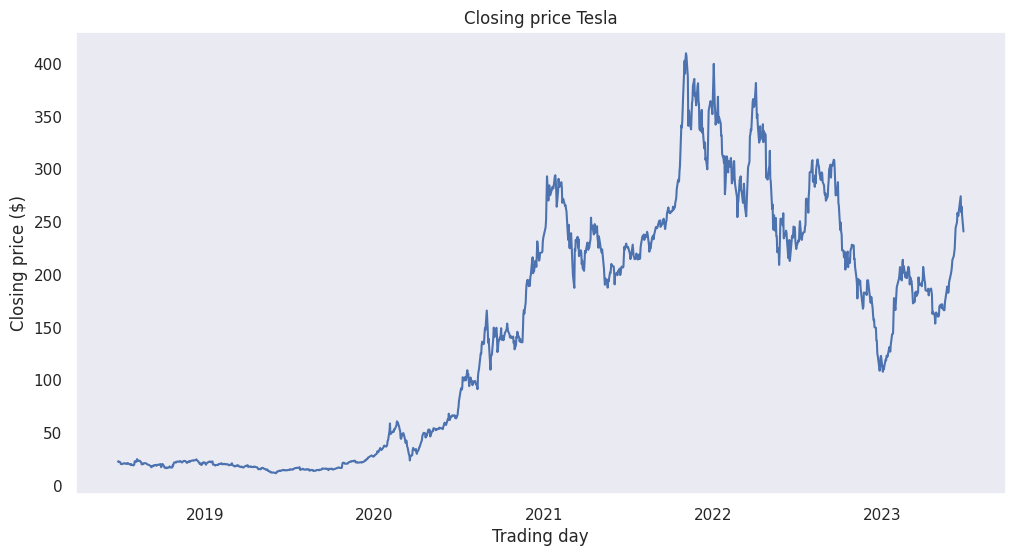

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(raw_data.Close)
plt.title('Closing price Tesla')
plt.ylabel('Closing price ($)')
plt.xlabel('Trading day')
plt.grid(False)
plt.show()

## Moving average
Let’s use the moving average model to smooth our time series. For that, we will use a helper function that will run the `moving average` model on a specified time window and it will plot the result smoothed curve.

Using function called plot_moving_average. This function takes three main parameters: `series`, `window`, and `plot_intervals`, with an `optional parameter scale`.

**series**: It represents the time series data that you want to apply the moving average on. The data should be provided as a pandas Series or a pandas DataFrame column.

**window**: It specifies the size of the moving window, which determines the number of data points used to calculate the moving average. For each data point, the function will compute the average of the previous window data points.

**plot_intervals**: This parameter is a boolean flag indicating whether to plot confidence intervals around the moving average. By default, it is set to False, meaning the confidence intervals will not be plotted. If set to True, the function will calculate and plot the upper and lower bounds around the moving average.

**scale**: This parameter determines the width of the confidence intervals when plot_intervals is set to True. The default value is 1.96, which corresponds to a 95% confidence interval for a large sample size under normal distribution assumptions. Changing this value will adjust the width of the plotted confidence intervals.

The function calculates the moving average using the **rolling function** from pandas, which applies a window-based operation on the provided series and `calculates the mean within each window`. The result is stored in the variable rolling_mean.

Confidence intervals provide a range of values within which we can be reasonably confident that the true value lies. To plot confidence intervals for smoothed values over different time frames (5, 30, and 90 days)

Apply a smoothing technique to reduce noise or fluctuations in the data. This could involve methods like moving averages or exponential smoothing, which calculate an average value over a specific time frame.

Plot upper and lower bounds based on the mean absolute error (MAE) and the standard deviation of the residuals.

In this case, the lower_bound and upper_bound represent the boundaries within which the smoothed values are expected to fall. The MAE is added to the scale times the deviation (standard deviation) to calculate these bounds. The scale parameter can be adjusted to control the width of the confidence interval.


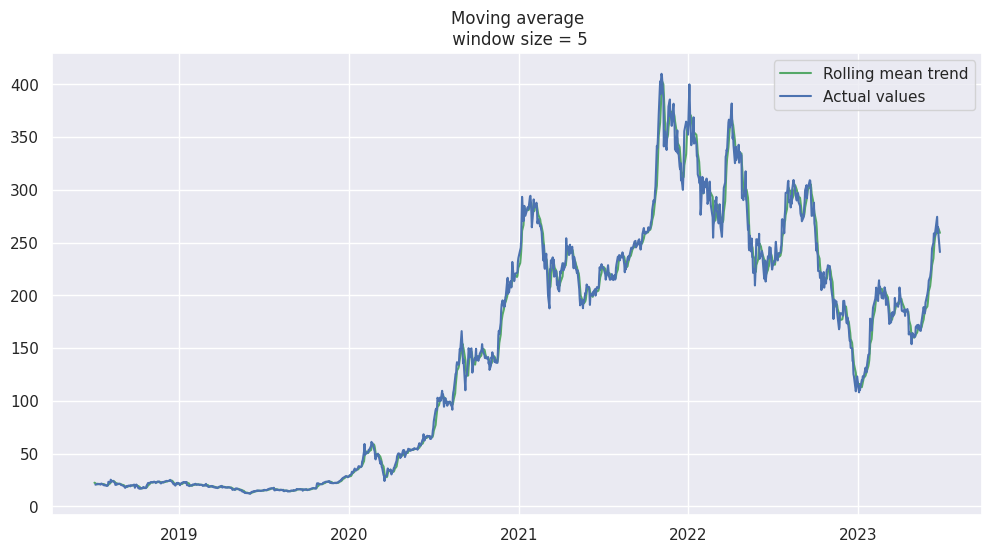

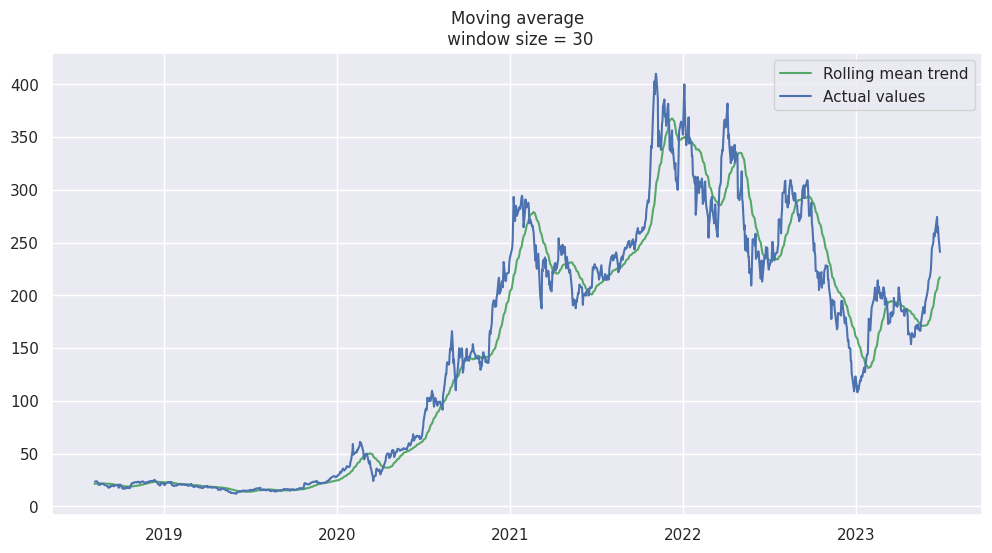

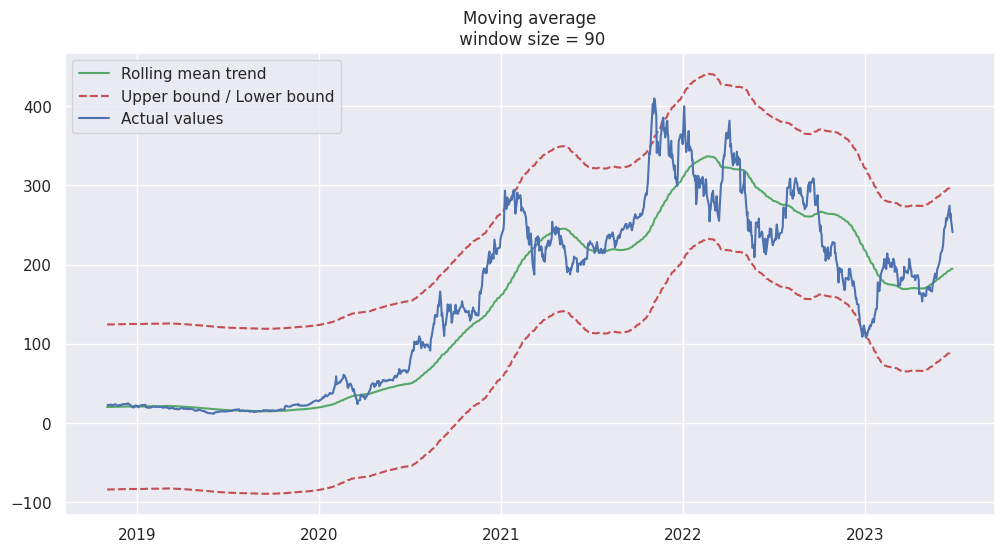

In [ ]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(12,6))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')

    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')

    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

#Smooth by the previous 5 days (by week)
plot_moving_average(raw_data.Close, 5)

#Smooth by the previous month (30 days)
plot_moving_average(raw_data.Close, 30)

#Smooth by previous quarter (60 days)
#plot_moving_average(raw_data.Close, 60, plot_intervals=True)

#Smooth by previous quarter (90 days)
plot_moving_average(raw_data.Close, 90, plot_intervals=True)

#Smooth by previous quarter (365 days)
#plot_moving_average(raw_data.Close, 365, plot_intervals=True)

### Exponential Smooting
Exponential smoothing is a popular technique used in time series analysis to forecast future values or to smooth out noise in a time series data set. Unlike simple moving averages that assign equal weights to all observations within a given window, exponential smoothing assigns exponentially decreasing weights as we move further back in the historical data.

In the context of exponential smoothing, instead of considering only the last 'n' values of the time series, all available observations are weighted. The most recent observations are given higher weights, while older observations receive progressively smaller weights. This weighting scheme places more emphasis on recent data points, reflecting the assumption that recent observations are more relevant or informative for forecasting than distant ones.

The specific weight assigned to each observation depends on the chosen smoothing factor or parameter. The smoothing factor typically ranges between 0 and 1, with higher values indicating more weight on recent observations. A common form of exponential smoothing is known as single exponential smoothing, where the smoothed value at time 't' is a weighted average of the previous smoothed value and the current observation.

By exponentially decreasing the weights as we move further back in the historical data, exponential smoothing can capture trends and patterns in the time series while dampening the influence of noisy or irrelevant data points. This makes it particularly useful for generating forecasts or obtaining a smoothed representation of the underlying trend in the data.

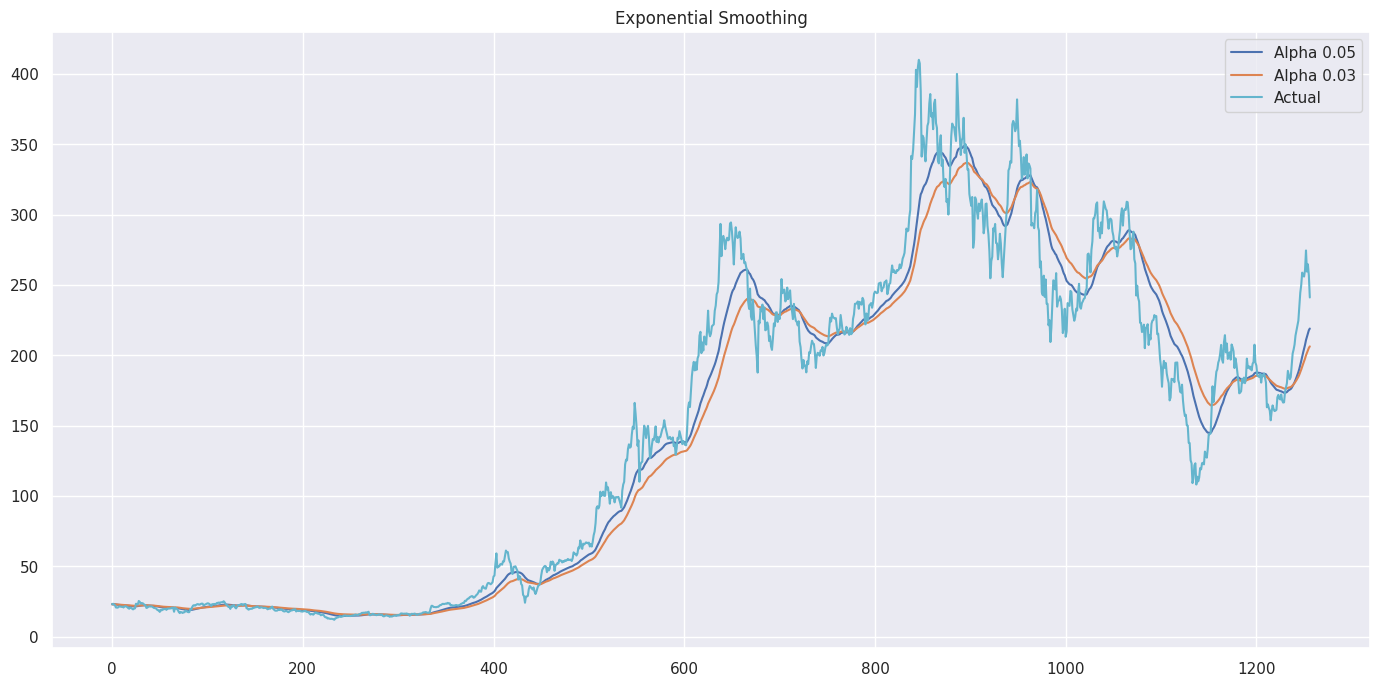

In [ ]:
# Function returns the list of smoothed values.
def exponential_smoothing(series, alpha):  #function performs exponential smoothing on a given time series with a specified smoothing factor `alpha`

    result = [series[0]] # initializes a list `result` with the first value of the input time series `series`.first smoothed value is assumed to be the same as the first value in the series.
    for n in range(1, len(series)):   # iterates over the remaining elements of the series starting from the second element (index 1).
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])   # For each element, it calculates the exponential smoothing value.
    return result                                                      # `alpha is the smoothing factor, `series[n]` is the current observation, and `result[n-1]` is the previous smoothed value.

def plot_exponential_smoothing(series, alphas):

    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

plot_exponential_smoothing(raw_data.Close, [0.05, 0.03]) # function is likely designed to visualize the effect of different smoothing factors on the time series data.

### **Double exponential smoothing**
Double exponential smoothing, also known as Holt's method, is an extension of exponential smoothing that incorporates the ability to capture and forecast trends in time series data. While exponential smoothing primarily focuses on capturing the level or average behavior of the data, double exponential smoothing additionally considers the trend component.

The method involves two components: the level component and the trend component. The level component represents the smoothed or average value of the data, while the trend component captures the direction and magnitude of the trend in the data.

The equations for double exponential smoothing are as follows:

Level equation:
L[t] = alpha * Y[t] + (1 - alpha) * (L[t-1] + T[t-1])

Trend equation:
T[t] = beta * (L[t] - L[t-1]) + (1 - beta) * T[t-1]

Forecast equation:
F[t+m] = L[t] + m * T[t]

Where:

- Y[t] is the actual value at time t in the time series.
- L[t] represents the level (smoothed value) at time t.
- T[t] denotes the trend component at time t.
- alpha is the smoothing factor for the level component, typically between 0 and 1.
- beta is the smoothing factor for the trend component, also typically between 0 and 1.
- m represents the number of periods ahead for forecasting.

The double exponential smoothing method updates the level and trend components based on the current observation and the previous level and trend values. It uses these updated components to generate smoothed values for the level and forecast future values by incorporating the trend.

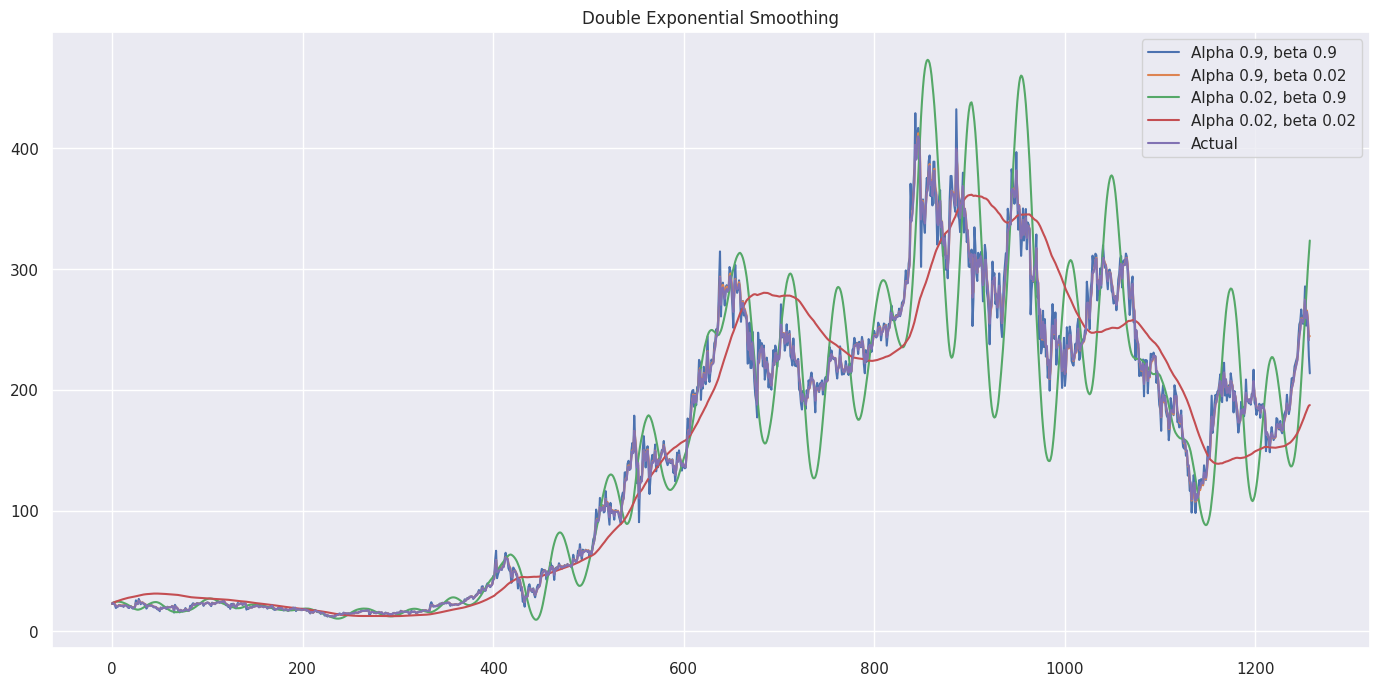

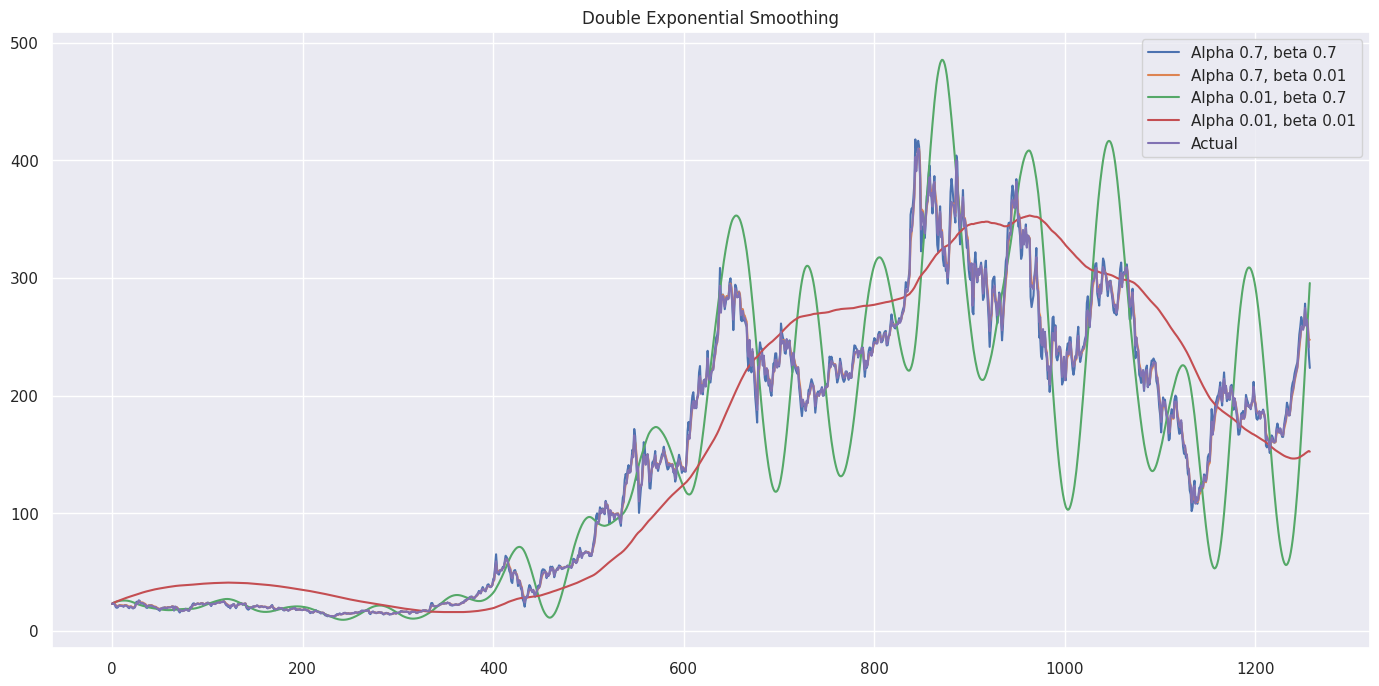

In [ ]:
def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):

    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

plot_double_exponential_smoothing(raw_data.Close, alphas=[0.9, 0.02], betas=[0.9, 0.02])
plot_double_exponential_smoothing(raw_data.Close, alphas=[0.7, 0.01], betas=[0.7, 0.01])

###**Modeling**
we must turn our series into a stationary process in order to model it. Therefore, let’s apply the Dickey-Fuller test to see if it is a stationary process.

The `Dickey-Fuller test` is a statistical test used to determine if a time series has a unit root, which indicates non-stationarity. Here's an explanation of the Dickey-Fuller test maximum in five lines:

- The Dickey-Fuller test computes a test statistic called the Dickey-Fuller statistic (ADF statistic) that compares the behavior of a time series with that of a random walk (a unit root process).
- The test hypothesis assumes the presence of a unit root (null hypothesis), indicating non-stationarity, while the alternative hypothesis assumes stationarity.

- The Dickey-Fuller test statistic is compared against critical values from the Dickey-Fuller distribution to determine if the null hypothesis should be rejected or not.
- If the test statistic is less than the critical values, the null hypothesis is rejected, indicating evidence of stationarity in the time series.
Conversely, if the test statistic is greater than the critical values, the null hypothesis is not rejected, suggesting that the time series has a unit root and is non-stationary.

<img src = "https://miro.medium.com/v2/resize:fit:1400/1*1DWtYSO_4YXfz6G4UzEDug.png">


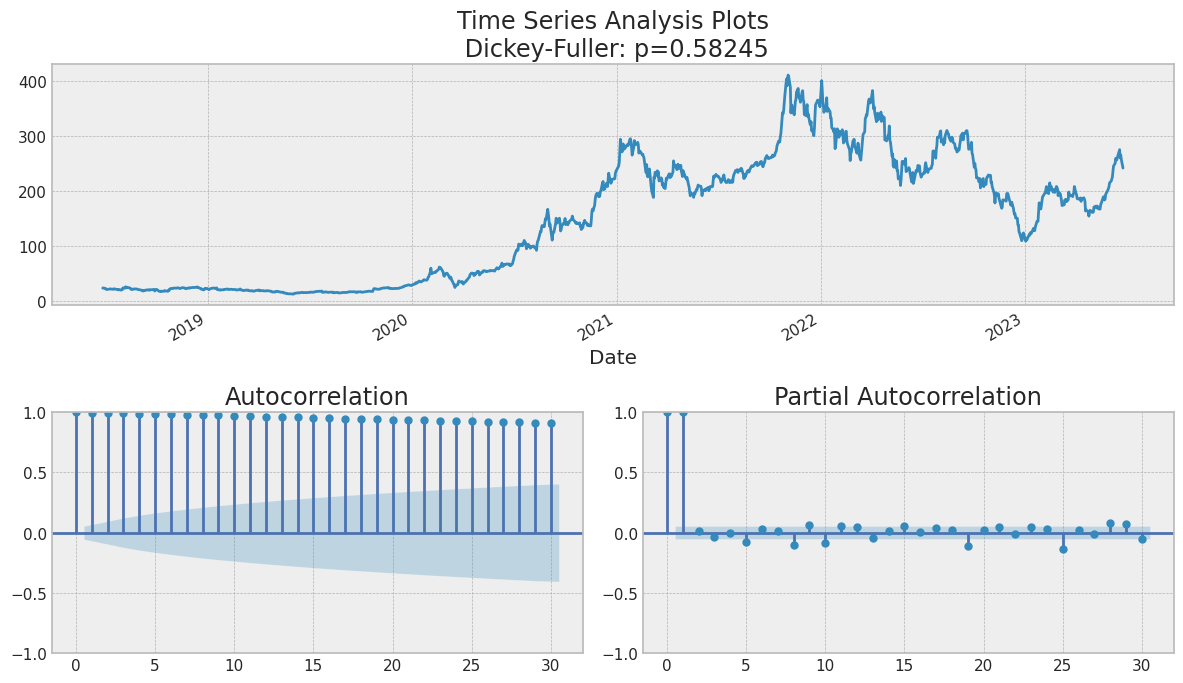

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):

    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

tsplot(raw_data.Close, lags=30)

By the Dickey-Fuller test, the time series is unsurprisingly non-stationary. in Autocorrelation plot, bell curve of autocorrelations are much smaller for lags and it seems that there is no clear seasonality (high autocorrection). In addition, in Partial autocorrection, most lags are statistically significant.

**To get ride of high Autocorrection**

Taking the first difference of a time series is a common approach to remove high autocorrelation and achieve stationarity. By subtracting the time series from itself with a lag of one day, you effectively calculate the difference between consecutive observations.

This differencing operation helps to `eliminate the trend component` and `reduce the autocorrelation in the data`. It is particularly useful when dealing with non-stationary time series that exhibit trends or other forms of systematic patterns.

By differencing the time series, you obtain a new series that represents the changes between consecutive observations. This differenced series is often referred to as a **"first difference" or a "differenced series."**

The first difference can help to make the time series stationary by removing the underlying trend or other non-stationary components. Stationarity is desirable for many time series analysis techniques and models, as it simplifies the relationships between observations and allows for more reliable and accurate analysis and forecasting.

Adding this line:
`data_diff = data.CLOSE - data.CLOSE.shift(1)` performs the differencing operation by subtracting the time series from itself with a lag of one day. This operation transforms the original series into a differenced series, which can be further analyzed or used for modeling purposes.

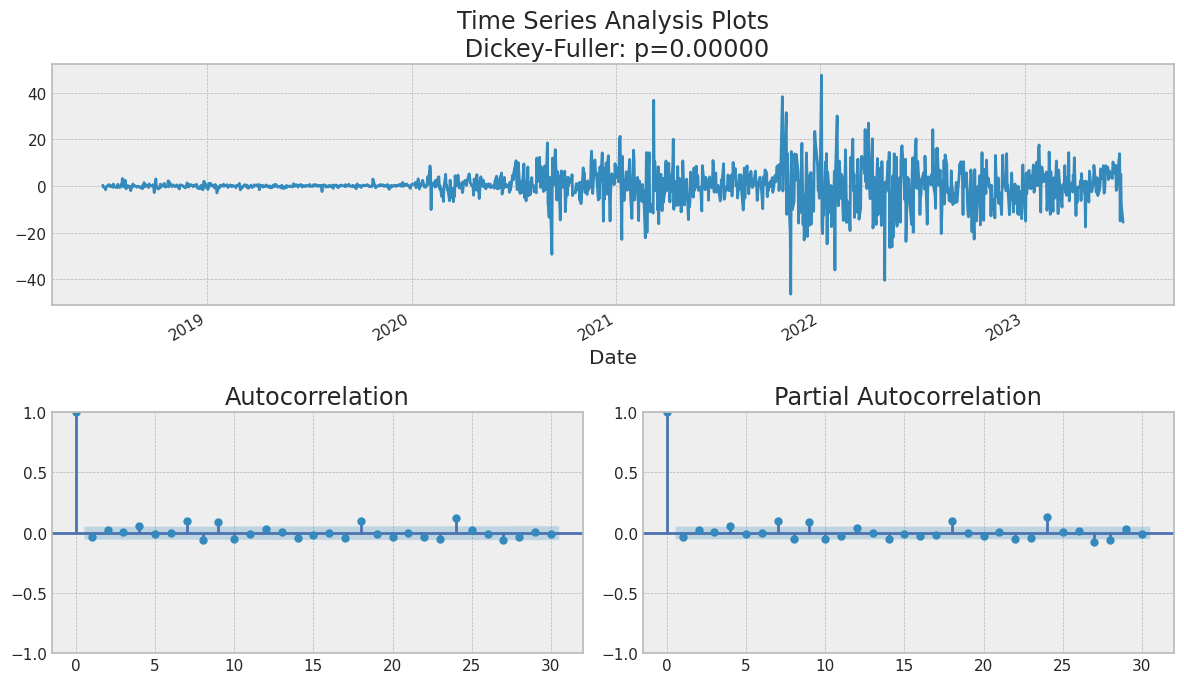

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):

    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

#tsplot(data.CLOSE, lags=30)

# Take the first difference to remove to make the process stationary
data_diff = raw_data.Close - raw_data.Close.shift(1)

tsplot(data_diff[1:], lags=30)

By examining the differenced series or performing additional tests, such as the Dickey-Fuller test, you can determine if the differencing operation successfully achieved stationarity and reduced the autocorrelation in the data.

### **SARIMA**
SARIMA (Seasonal Autoregressive Integrated Moving Average) models are a popular class of models used for time series forecasting, particularly for data with seasonal patterns. SARIMA models incorporate the parameters p, d, q, P, D, Q, and s to capture the autoregressive, differencing, moving average, and seasonal components of the data.

The parameters in SARIMA models have the following interpretations:

p: The autoregressive order, which represents the number of lagged observations included in the model. It captures the dependency of the current value on past values.

d: The differencing order, which specifies the number of times the data needs to be differenced to achieve stationarity. Differencing is used to remove trends or other non-stationary patterns.

q: The moving average order, indicating the number of lagged forecast errors included in the model. It accounts for the dependency of the current value on past forecast errors.

P: The seasonal autoregressive order, similar to the autoregressive order (p), but for the seasonal component. It captures the seasonal dependency of the current value on past seasonal values.

D: The seasonal differencing order, analogous to the differencing order (d), but for the seasonal component. It specifies the number of times the seasonal data needs to be differenced to achieve seasonal stationarity.

Q: The seasonal moving average order, similar to the moving average order (q), but for the seasonal component. It captures the dependency of the current value on past seasonal forecast errors.

s: The length of the seasonal cycle or the number of observations per season. It defines the period for the seasonal component and helps identify the lag between seasonal values.

When choosing the values for p, d, q, P, D, Q, and s, it's common to explore various combinations to find the best model fit for the data. You can iterate over different combinations of these parameters and evaluate the model's performance using techniques like cross-validation, information criteria (e.g., AIC or BIC), or out-of-sample forecasting accuracy.


In [ ]:
#Set initial values and some bounds
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 5

#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Train many SARIMA models to find the best set of parameters
def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC

        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """

    results = []
    best_aic = float('inf')

    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(raw_data.Close, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue

        aic = model.aic

        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)

    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)

#Set parameters that give the lowest AIC (Akaike Information Criteria)
p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(raw_data.Close, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())

  0%|          | 0/625 [00:00<?, ?it/s]

                                         SARIMAX Results                                         
Dep. Variable:                                     Close   No. Observations:                 1257
Model:             SARIMAX(2, 1, 4)x(4, 1, [1, 2, 3], 5)   Log Likelihood               -4247.160
Date:                                   Tue, 27 Jun 2023   AIC                           8522.321
Time:                                           22:49:34   BIC                           8594.164
Sample:                                                0   HQIC                          8549.328
                                                  - 1257                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9682      0.041    -23.617      0.000    

## Tesla price in shorter time frame
Between 2021-09-21 and 2023-06-26

In [ ]:
import yfinance as yf

# Define the ticker symbol for the S&P 500 index
ticker_symbol = "AAPL"

# Define the desired date range for the historical data
start_date = "2021-09-21"
end_date = "2023-06-26"

# Download the historical data using yfinance
data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Print the downloaded data
print(data)

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2021-09-21  143.929993  144.600006  142.779999  143.429993  141.981064   
2021-09-22  144.449997  146.429993  143.699997  145.850006  144.376648   
2021-09-23  146.649994  147.080002  145.639999  146.830002  145.346756   
2021-09-24  145.660004  147.470001  145.559998  146.919998  145.435806   
2021-09-27  145.470001  145.960007  143.820007  145.369995  143.901489   
...                ...         ...         ...         ...         ...   
2023-06-16  186.729996  186.990005  184.270004  184.919998  184.919998   
2023-06-20  184.410004  186.100006  184.410004  185.009995  185.009995   
2023-06-21  184.899994  185.410004  182.589996  183.960007  183.960007   
2023-06-22  183.740005  187.050003  183.669998  187.000000  187.000000   
2023-06-23  185.550003  187.559998  185.009

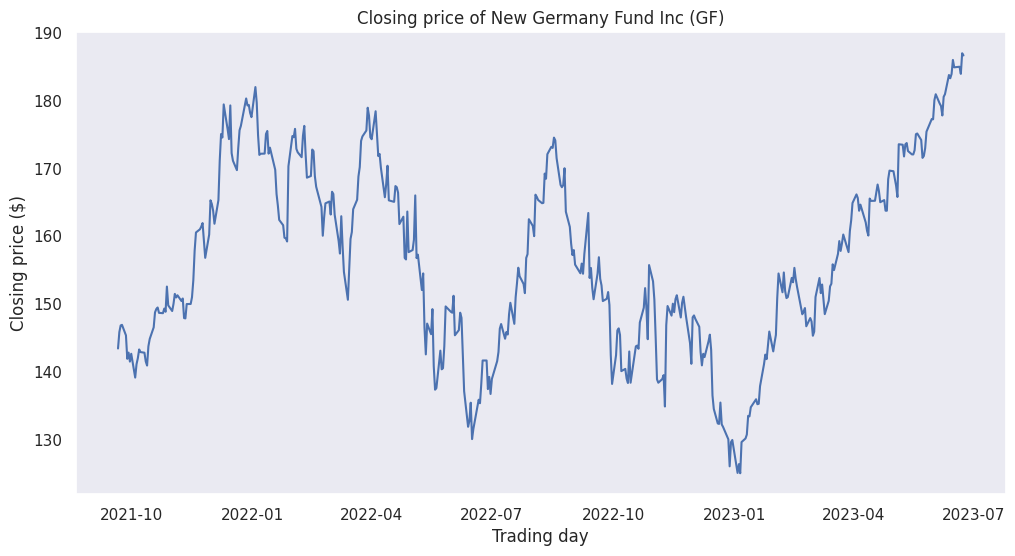

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(data.Close)
plt.title('Closing price of New Germany Fund Inc (GF)')
plt.ylabel('Closing price ($)')
plt.xlabel('Trading day')
plt.grid(False)
plt.show()

## Moving average
Let’s use the moving average model to smooth our time series. For that, we will use a helper function that will run the `moving average` model on a specified time window and it will plot the result smoothed curve:

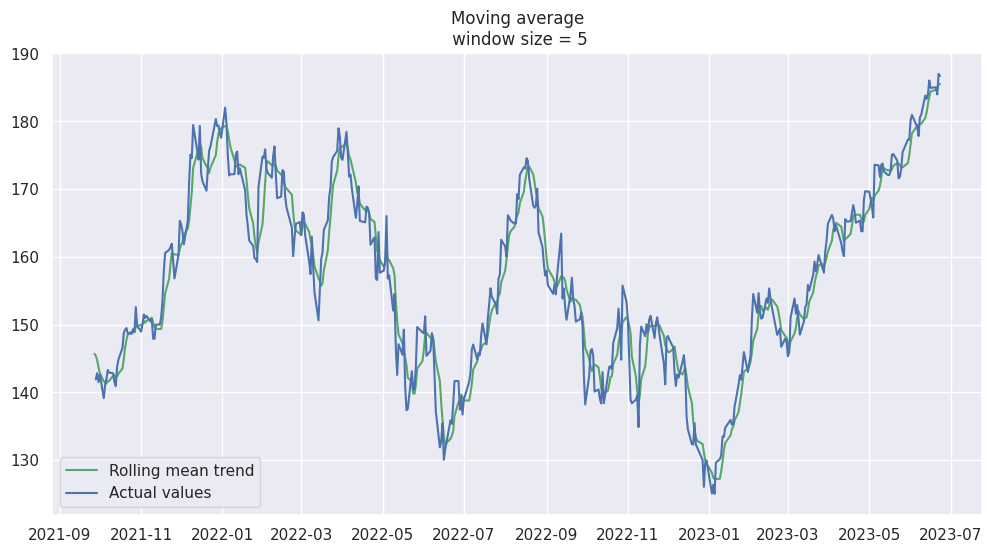

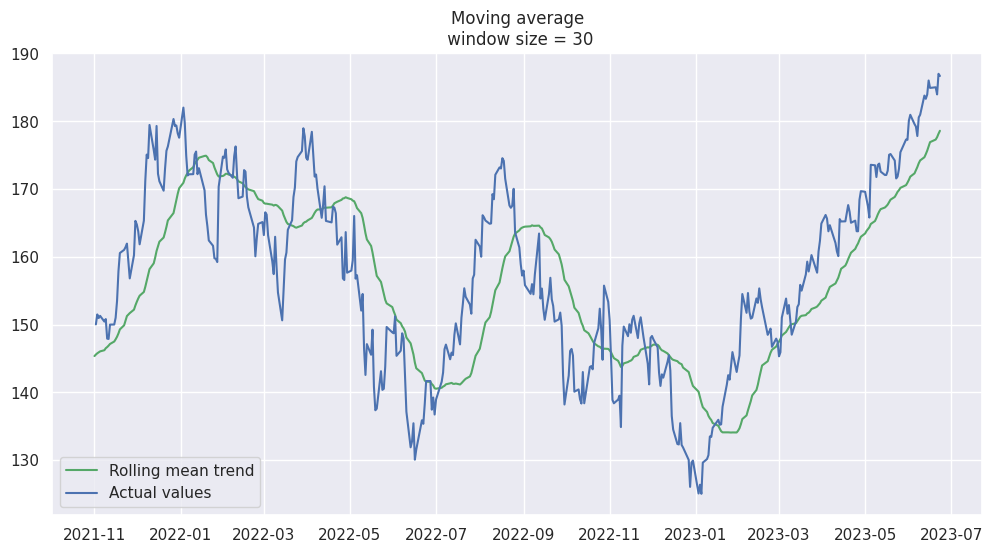

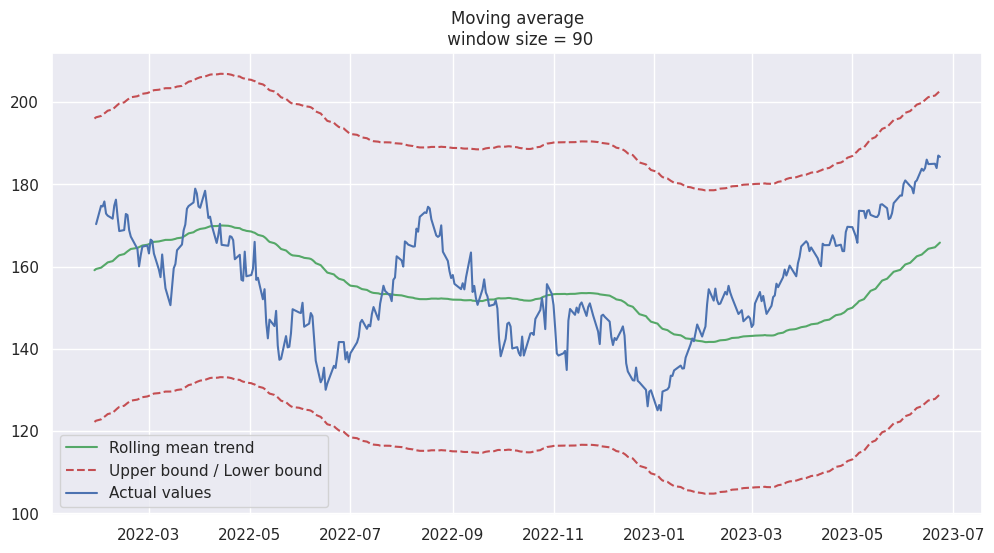

In [ ]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(12,6))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')

    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')

    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

#Smooth by the previous 5 days (by week)
plot_moving_average(data.Close, 5)

#Smooth by the previous month (30 days)
plot_moving_average(data.Close, 30)

#Smooth by previous quarter (90 days)
plot_moving_average(data.Close, 90, plot_intervals=True)

### Exponential smoothing
let’s take a look at what happens if instead of weighting the last nn values of the time series we start weighting all available observations while exponentially decreasing weights as we move further back in historical data.

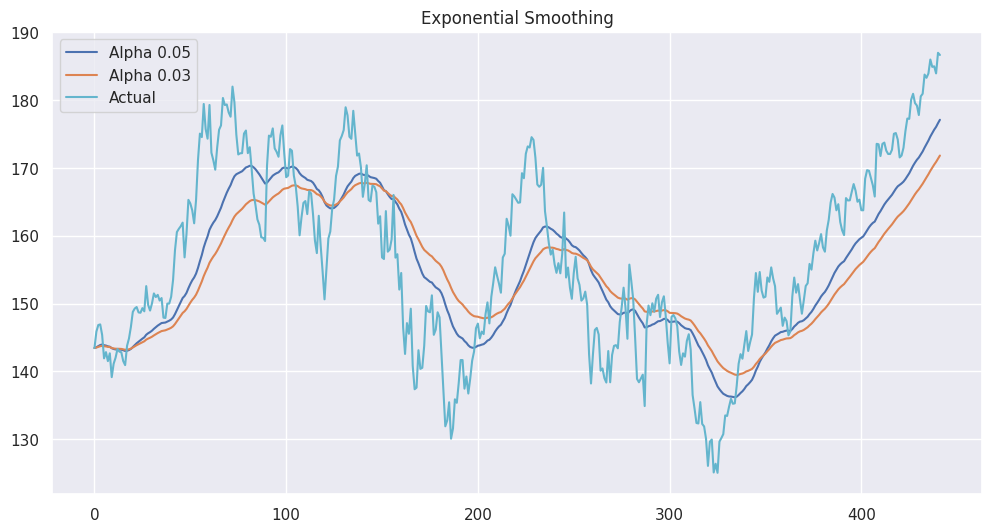

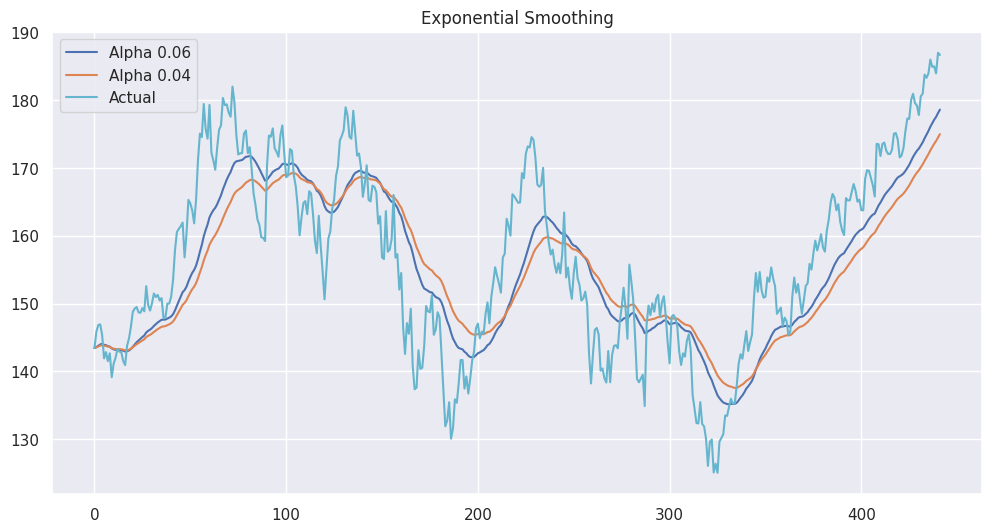

In [ ]:
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def plot_exponential_smoothing(series, alphas):

    plt.figure(figsize=(12, 6))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

plot_exponential_smoothing(data.Close, [0.05, 0.03])
#plot_exponential_smoothing(data.Close, [0.06, 0.04])


### Double exponential smooting

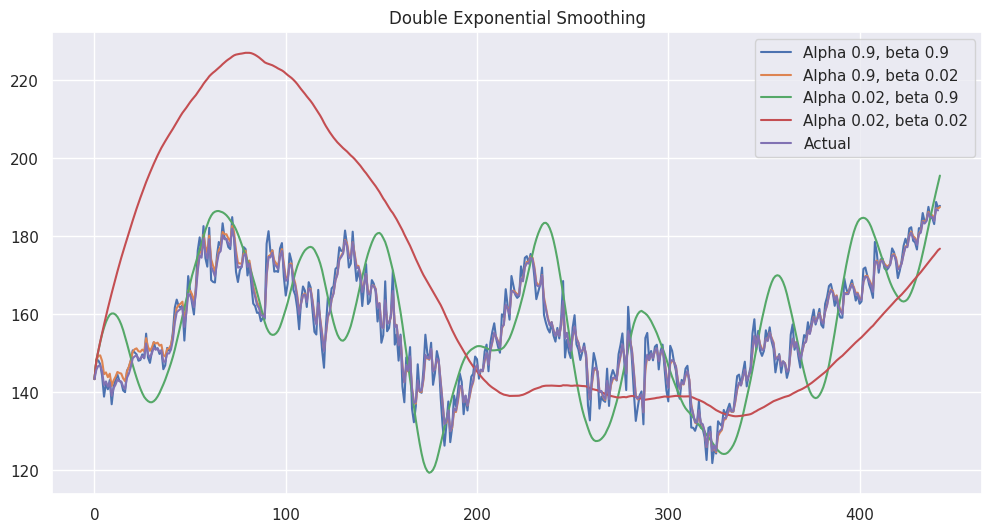

In [ ]:
def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):

    plt.figure(figsize=(12, 6))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

plot_double_exponential_smoothing(data.Close, alphas=[0.9, 0.02], betas=[0.9, 0.02])

## Modelling
As outlined previously, we must turn our series into a stationary process in order to model it. Therefore, let’s apply the Dickey-Fuller test to see if it is a stationary process:

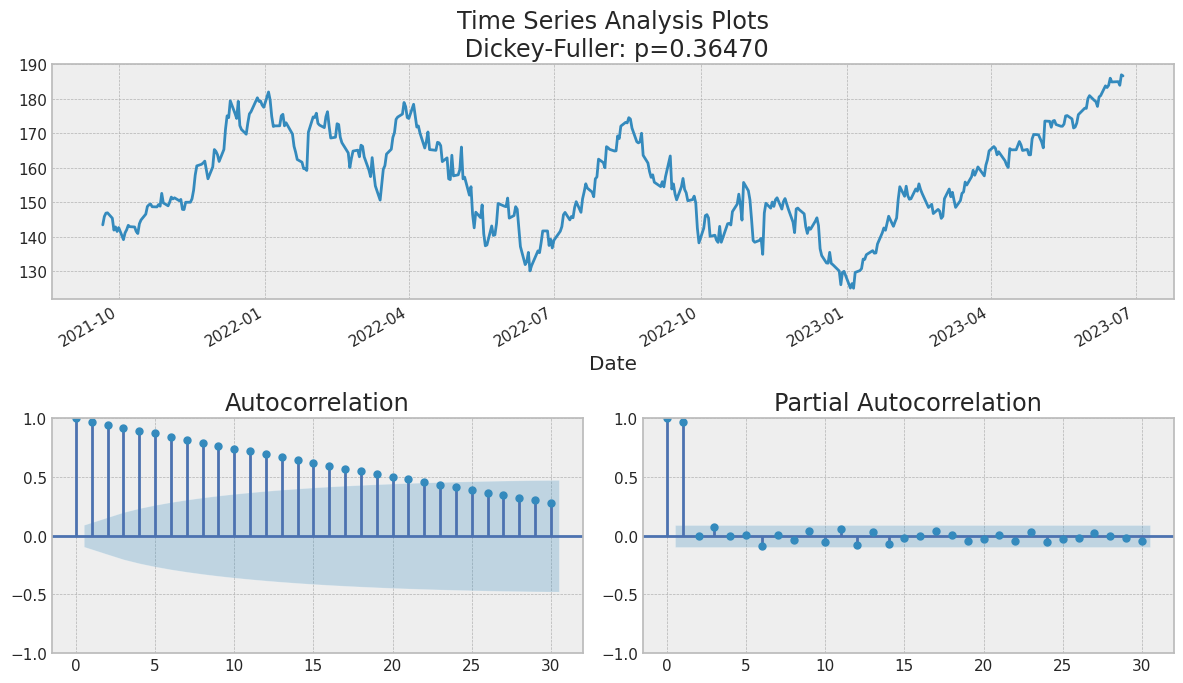

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):

    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

tsplot(data.Close, lags=30)


By the Dickey-Fuller test, the time series is unsurprisingly non-stationary. Also, looking at the autocorrelation plot, we see that it is very high, and it seems that there is no clear seasonality.

Therefore, to get rid of the high autocorrelation and to make the process stationary, let’s take the first difference (line 23 in the code block). We simply subtract the time series from itself with a lag of one day, and we get:

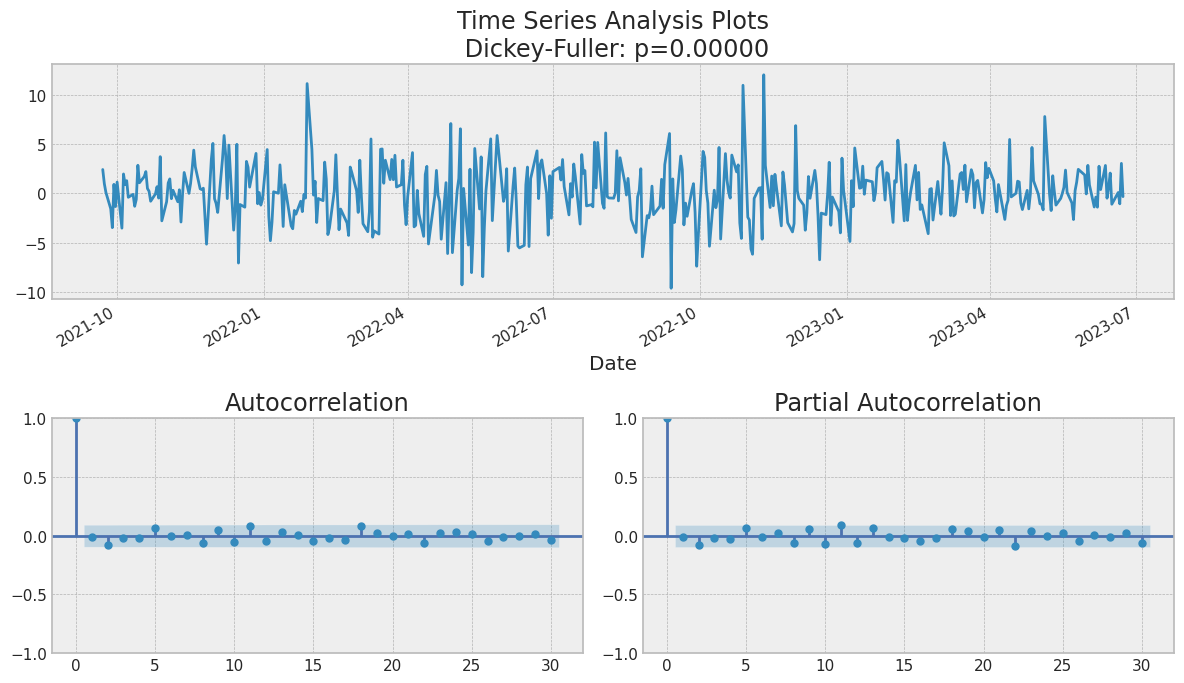

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):

    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

#tsplot(data.CLOSE, lags=30)

# Take the first difference to remove to make the process stationary
data_diff = data.Close - data.Close.shift(1)

tsplot(data_diff[1:], lags=30)

### SARIMA
For SARIMA, we first define a few parameters and a range of values for other parameters to generate a list of all possible combinations of p, q, d, P, Q, D, s.

Now, in the code cell above, we have 625 different combinations! We will try each combination and train SARIMA with each so to find the best performing model. This might take while depending on your computer’s processing power.

In [ ]:
#Set initial values and some bounds
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 5

#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Train many SARIMA models to find the best set of parameters
def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC

        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """

    results = []
    best_aic = float('inf')

    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(data.Close, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue

        aic = model.aic

        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)

    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)

#Set parameters that give the lowest AIC (Akaike Information Criteria)
p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(data.Close, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())

  0%|          | 0/625 [00:00<?, ?it/s]

                                     SARIMAX Results                                     
Dep. Variable:                             Close   No. Observations:                  442
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 5)   Log Likelihood               -1100.655
Date:                           Wed, 28 Jun 2023   AIC                           2209.310
Time:                                   04:39:21   BIC                           2225.620
Sample:                                        0   HQIC                          2215.747
                                           - 442                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9069      0.033    -27.595      0.000      -0.971      -0.843
ma.L1          0.9777      0.018     55.515

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product

#define the mean average percentage error (MAPE), as this will be our error metric.

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [ ]:
import yfinance as yf

# Define the ticker symbol for the S&P 500 index
ticker_symbol = "AAPL"

# Define the desired date range for the historical data
start_date = "2023-01-01"
end_date = "2023-06-26"

# Download the historical data using yfinance
data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Print the downloaded data
print(data)

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-01-03  130.279999  130.899994  124.169998  125.070000  124.706833   
2023-01-04  126.889999  128.660004  125.080002  126.360001  125.993095   
2023-01-05  127.129997  127.769997  124.760002  125.019997  124.656982   
2023-01-06  126.010002  130.289993  124.889999  129.619995  129.243622   
2023-01-09  130.470001  133.410004  129.889999  130.149994  129.772079   
...                ...         ...         ...         ...         ...   
2023-06-16  186.729996  186.990005  184.270004  184.919998  184.919998   
2023-06-20  184.410004  186.100006  184.410004  185.009995  185.009995   
2023-06-21  184.899994  185.410004  182.589996  183.960007  183.960007   
2023-06-22  183.740005  187.050003  183.669998  187.000000  187.000000   
2023-06-23  185.550003  187.559998  185.009

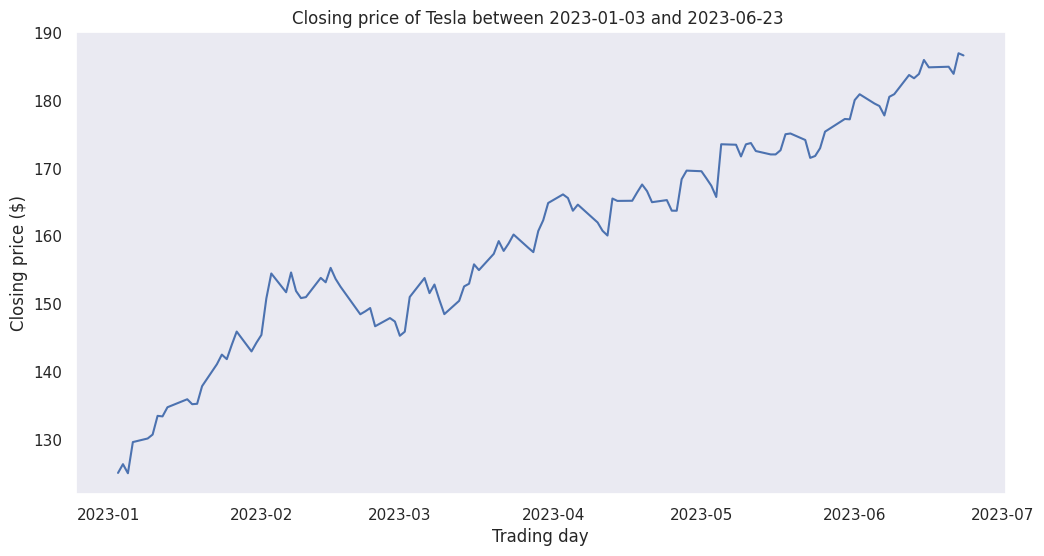

In [ ]:
# Plot closing price

plt.figure(figsize=(12, 6))
plt.plot(data.Close)
plt.title('Closing price of Tesla between 2023-01-03 and 2023-06-23 ')
plt.ylabel('Closing price ($)')
plt.xlabel('Trading day')
plt.grid(False)
plt.show()

### Moving Average

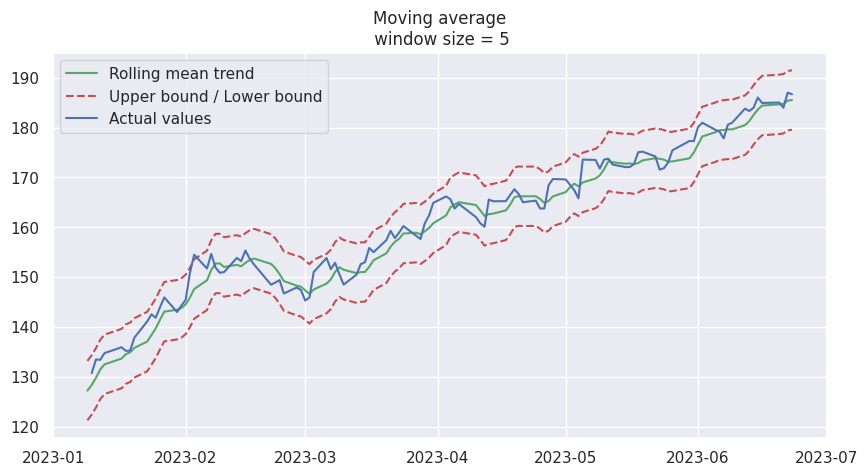

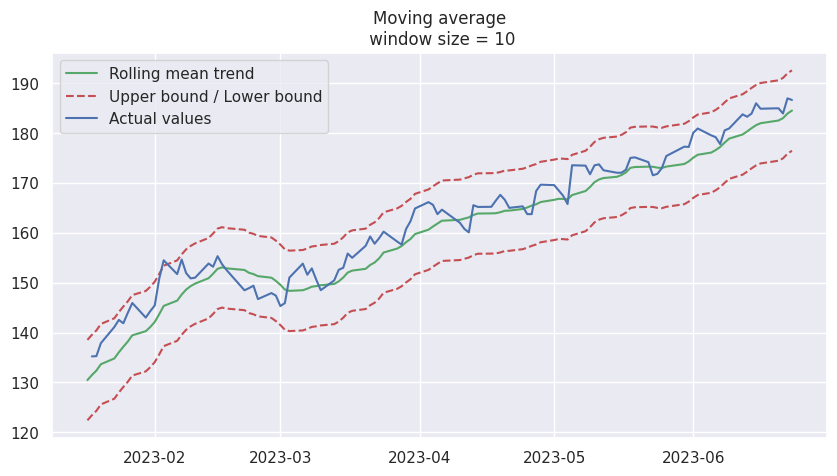

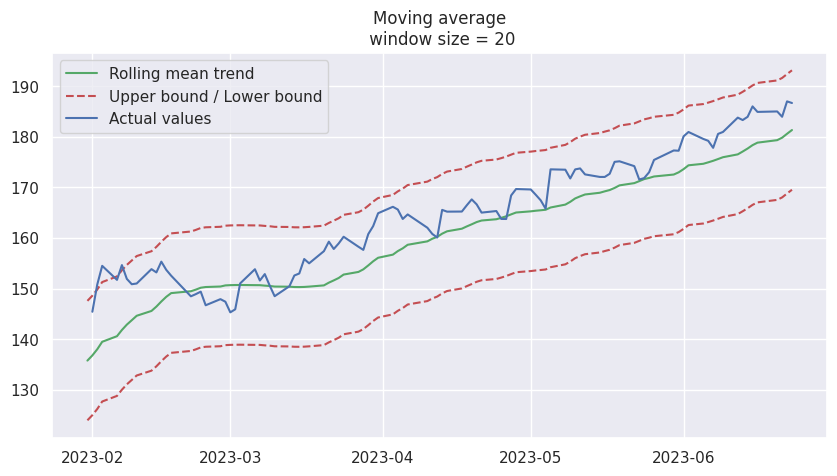

In [ ]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(10,5))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')

    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')

    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

#Smooth by the previous 5 days (by week)
plot_moving_average(data.Close, 5,plot_intervals=True)

#Smooth by the previous month (10 days)
plot_moving_average(data.Close, 10, plot_intervals=True)

#Smooth by previous quarter (20 days)
plot_moving_average(data.Close, 20, plot_intervals=True)

### Exponential smoothing

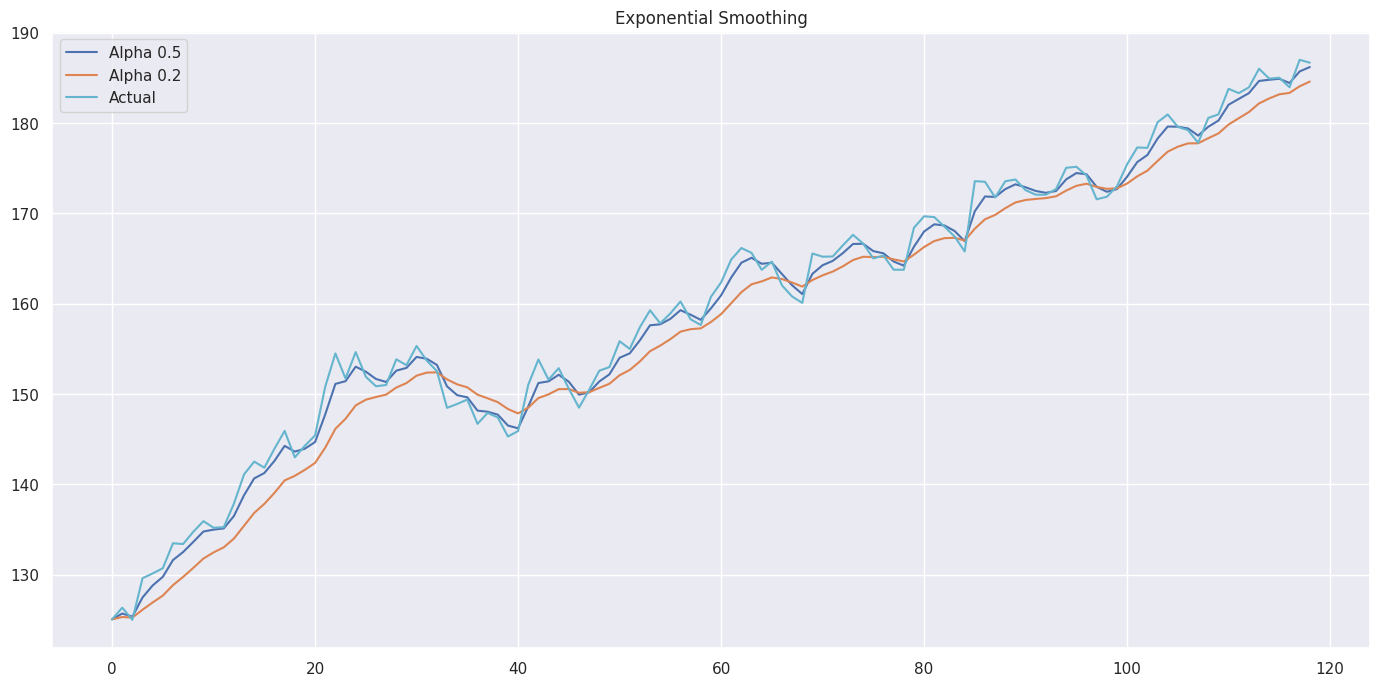

In [ ]:
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def plot_exponential_smoothing(series, alphas):

    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

plot_exponential_smoothing(data.Close, [0.5, 0.2])

### Double exponential smooting

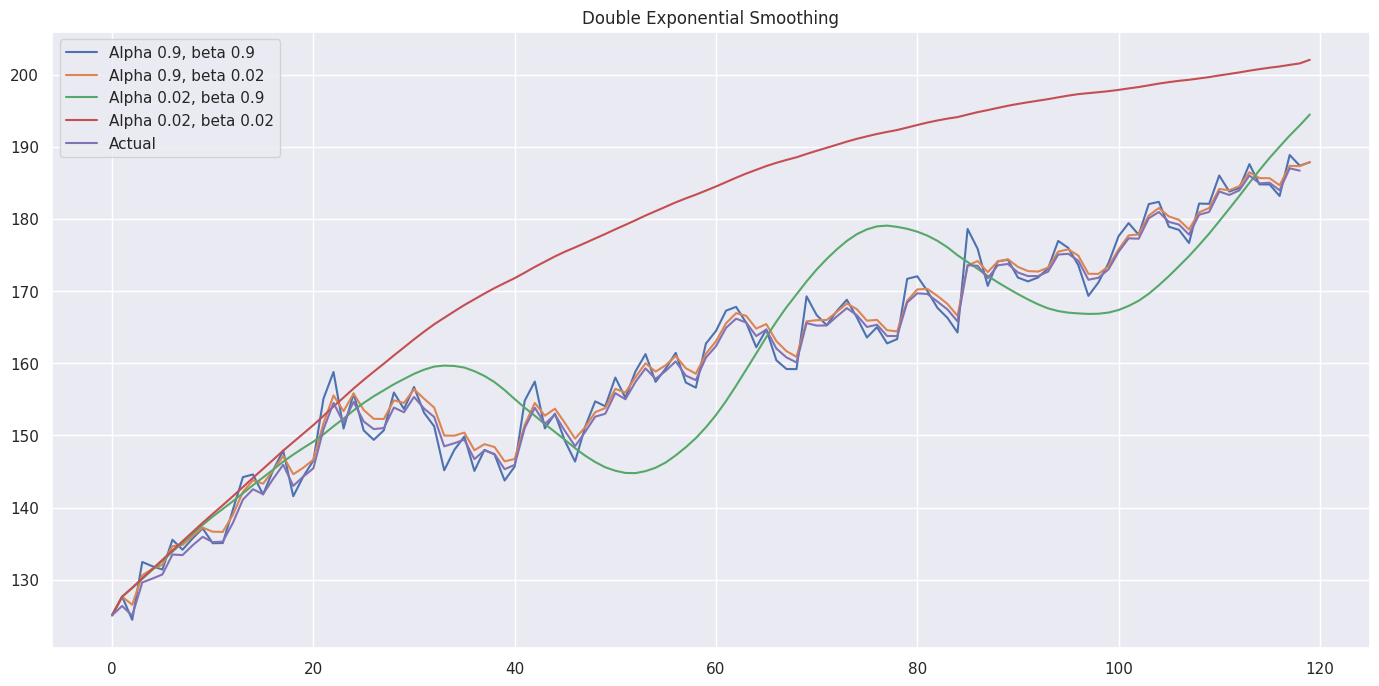

In [ ]:
def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):

    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

plot_double_exponential_smoothing(data.Close, alphas=[0.9, 0.02], betas=[0.9, 0.02])

### Modelling

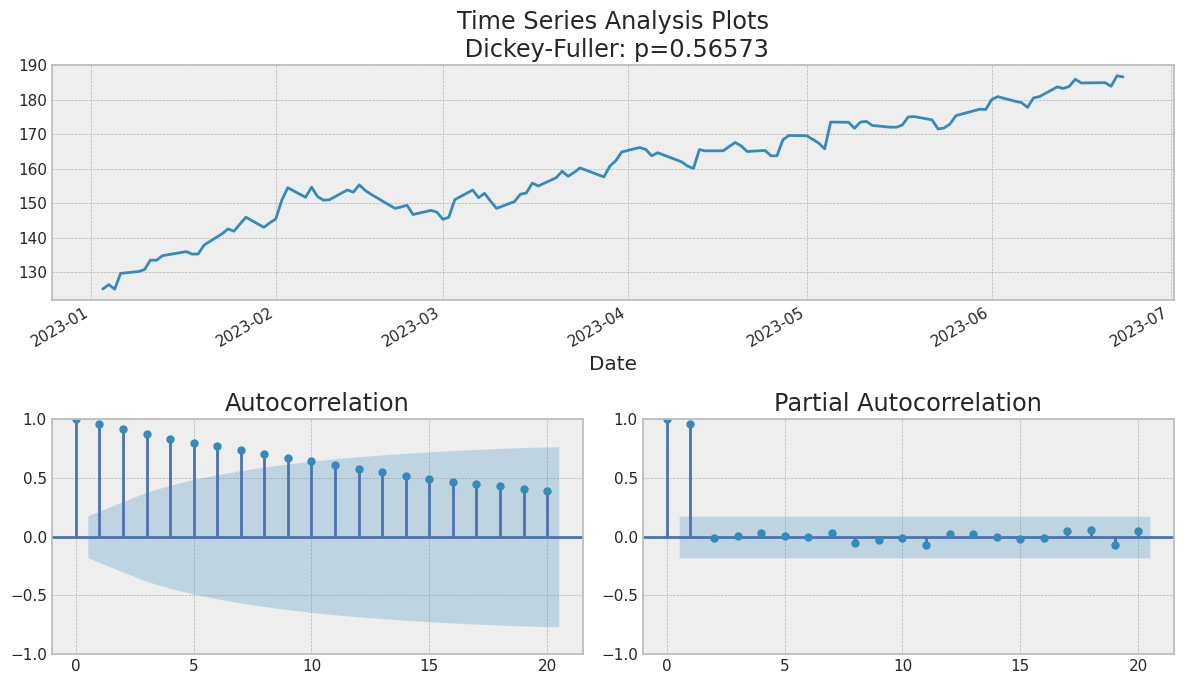

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):

    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

tsplot(data.Close, lags=20)


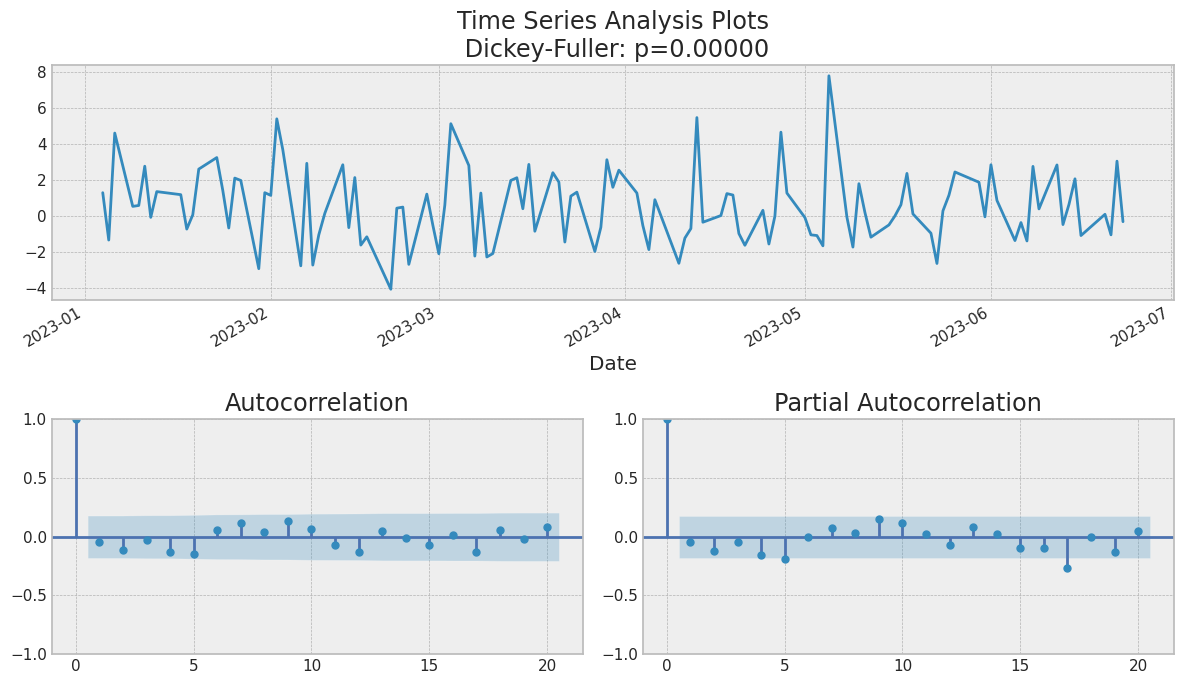

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):

    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

#tsplot(data.CLOSE, lags=30)

# Take the first difference to remove to make the process stationary
data_diff = data.Close - data.Close.shift(1)

tsplot(data_diff[1:], lags=20)

### SARIMA

In [ ]:
#Set initial values and some bounds
ps = range(0, 5)  # number of lag observations included in the model's autoregressive component
d = 1             # number of times differencing is applied to the time series to make it stationary.
qs = range(0, 5)  # number of lagged forecast errors included in the moving average component of the model.
Ps = range(0, 5)  # P is range of values for the seasonal autoregressive order parameter. It is used in SARIMA models to capture seasonality in the data.
D = 1             # number of times seasonal differencing is applied to the time series
Qs = range(0, 5)  # Q: range of values for the seasonal MA order parameter. It is used in SARIMA models to capture seasonality in the data.
s = 5             # the number of time steps in each season of the data.

#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Train many SARIMA models to find the best set of parameters
def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC

        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """

    results = []
    best_aic = float('inf')

    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(data.Close, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue

        aic = model.aic

        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)

    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)

#Set parameters that give the lowest AIC (Akaike Information Criteria)
p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(data.Close, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())

  0%|          | 0/625 [00:00<?, ?it/s]

                                      SARIMAX Results                                      
Dep. Variable:                               Close   No. Observations:                  119
Model:             SARIMAX(4, 1, 4)x(0, 1, [1], 5)   Log Likelihood                -239.829
Date:                             Wed, 28 Jun 2023   AIC                            499.657
Time:                                     17:44:58   BIC                            526.931
Sample:                                          0   HQIC                           510.725
                                             - 119                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2450      0.090     13.877      0.000       1.069       1.421
ar.L2         -1.2582      

When I used a larger number of consecutive days (1257 days in your case), it is possible to have a higher coefficient of Sigma2 because the model has to capture more variability and potential patterns in the data. On the other hand, with fewer data points (119 days), the model has less information to work with, so the coefficient of Sigma2 might be lower.

Changing the values of the variables you mentioned (such as p, d, q, Ps, D, Qs, and s) in the SARIMA model can potentially affect the coefficient of Sigma2. By trying different combinations of these parameters, you can explore different models and assess their goodness of fit using metrics such as the Akaike Information Criterion (AIC) or the Bayesian Information Criterion (BIC). The goal is to find a model that minimizes these criteria while still capturing the important patterns and variability in the data.

However, it's important to note that the coefficient of Sigma2 alone might not be the only indicator of model performance. You should also consider other diagnostic measures, such as examining the residuals for autocorrelation or heteroscedasticity, to evaluate the overall adequacy of the model.